# Multiple GPU support

## Overview

Nowadays production grade solutions are using multiple machines with multiple GPUs to run the training of neural networks in reasonable time. This tutorial will show you how to run DALI pipelines using multiple GPUs.

## Run pipeline on selected GPU

Let's start with the pipeline very similar to `HybridPipeline` from [Getting started](../../getting started.ipynb) section. It uses the GPU to decode the images (notice the `mixed` value of `device`).

In [1]:
import nvidia.dali.ops as ops
import nvidia.dali.types as types
from nvidia.dali.pipeline import Pipeline

image_dir = "../data/images"
batch_size = 4

class TestPipeline(Pipeline):
    def __init__(self, batch_size, num_threads, device_id):
        super(TestPipeline, self).__init__(batch_size, num_threads, device_id)
        self.input = ops.FileReader(file_root = image_dir, random_shuffle = False)
        self.decode = ops.ImageDecoder(device = 'mixed', output_type = types.RGB)

    def define_graph(self):
        jpegs, labels = self.input()
        images = self.decode(jpegs)

        return (images, labels)

To run this pipeline on selected GPU we need to adjust the `device_id` parameter value. ID ordinals are consistent with CUDA device IDs.
Let's run it on the GPU with ID = 1.

Please be advised that the code below will work for systems with at least 2 GPUs available.

In [2]:
# Create and build the pipeline
pipe = TestPipeline(batch_size, 1, device_id = 1)
pipe.build()

# Run pipeline on selected device
images, labels = pipe.run()

Now we can print the `images`.

In [3]:
from __future__ import division
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
%matplotlib inline

def show_images(image_batch):
    columns = 4
    rows = (batch_size + 1) // (columns)
    fig = plt.figure(figsize = (32,(32 // columns) * rows))
    gs = gridspec.GridSpec(rows, columns)
    for j in range(rows*columns):
        plt.subplot(gs[j])
        plt.axis("off")
        plt.imshow(image_batch.at(j))

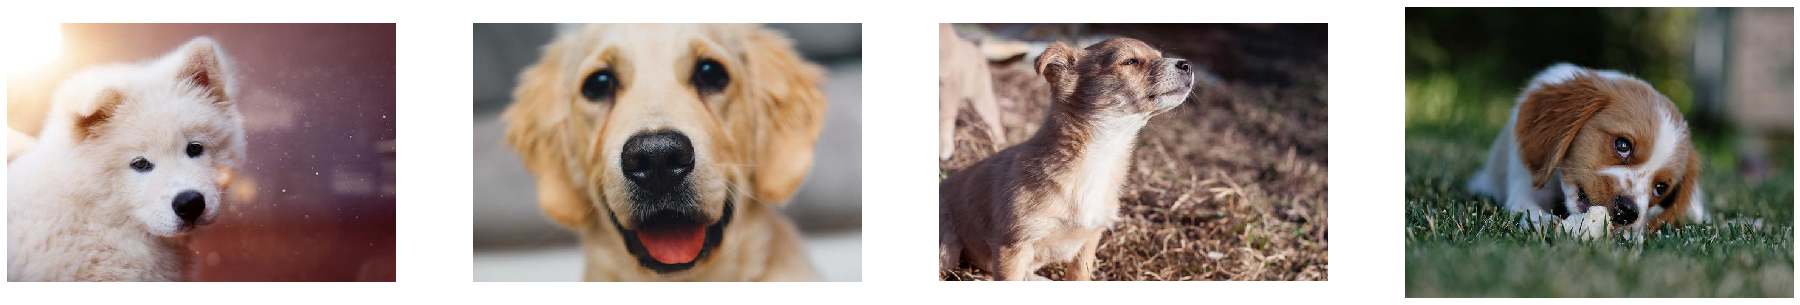

In [4]:
show_images(images.as_cpu())

## Sharding

It is not enough to run pipelines on different GPUs. During the training we want each GPU to handle different samples at the same time. This technique is called sharding. We divide the dataset into multiple parts or shards. Then, each GPU gets its own shard to process.

![sharding.png](../../../images/sharding.png)

In DALI sharding is controlled by two parameters of every reader op: `shard_id` and `num_shards`. Let's take a quick look at those parameters in the documentation for `FileReader`.

`help(ops.FileReader)`:

    num_shards : int, optional, default = 1
                 Partition the data into this many parts (used for multiGPU training).
                   
    shard_id : int, optional, default = 0
               Id of the part to read

`ShardedPipeline` below shows how to use `shard_id` and `num_shards`.

In [5]:
class ShardedPipeline(Pipeline):
    def __init__(self, batch_size, num_threads, device_id, shard_id, num_shards):
        super(ShardedPipeline, self).__init__(batch_size, num_threads, device_id)
        self.input = ops.FileReader(
            file_root = image_dir, random_shuffle = False, shard_id = shard_id, num_shards = num_shards)
        self.decode = ops.ImageDecoder(device = 'mixed', output_type = types.RGB)

    def define_graph(self):
        jpegs, labels = self.input()
        images = self.decode(jpegs)

        return (images, labels)

Now we are ready to create and run two pipelines on two different GPUs taking samples from different shards of the dataset.

In [6]:
# Create and build pipelines
pipe_one = ShardedPipeline(batch_size, 1, device_id = 0, shard_id = 0, num_shards = 2)
pipe_one.build()

pipe_two = ShardedPipeline(batch_size, 1, device_id = 1, shard_id = 1, num_shards = 2)
pipe_two.build()

# Run pipelines
images_one, labels_one = pipe_one.run()
images_two, labels_two = pipe_two.run()

When images are printed we can clearly see that each pipeline processed different samples.

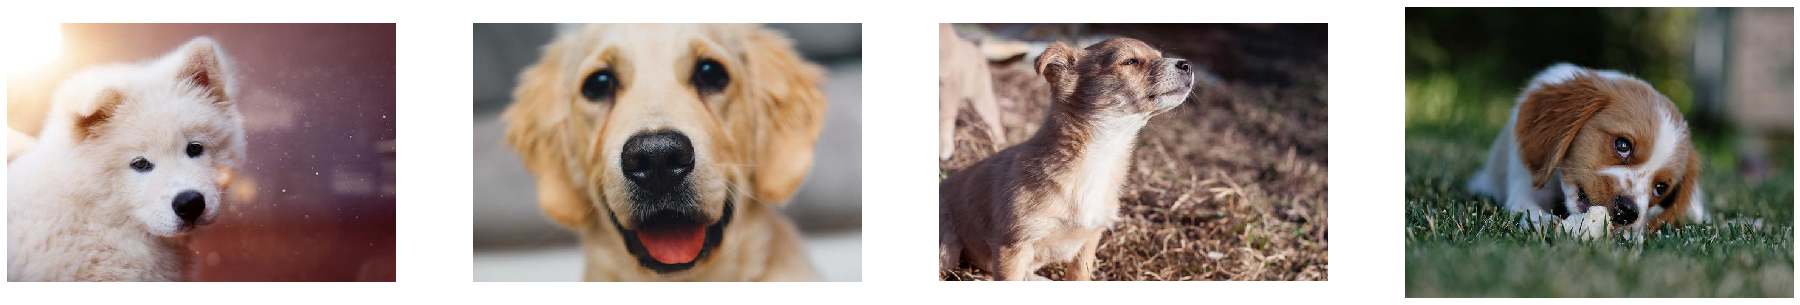

In [7]:
show_images(images_one.as_cpu())

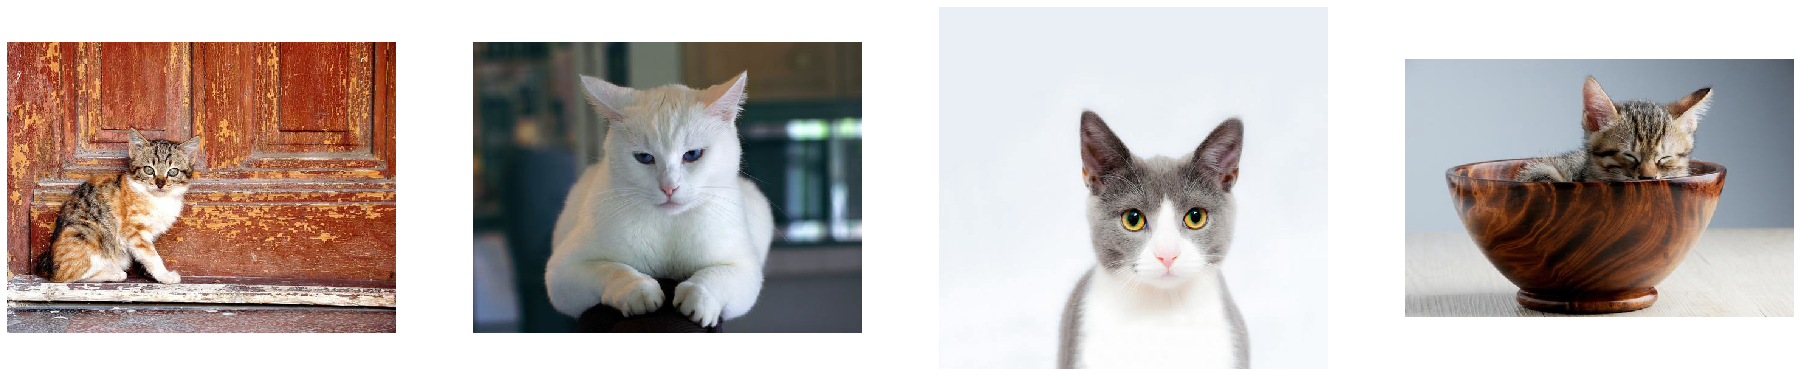

In [8]:
show_images(images_two.as_cpu())

In this simple tutorial we show how to run DALI pipelines on multiple GPUs using sharding. For more comprehensive examples within different frameworks please check out training scripts for ResNet50 for [MXNet](../../use_cases/mxnet-resnet50.ipynb), [PyTorch](../../use_cases/pytorch/resnet50/pytorch-resnet50.rst) and [TensorFlow](../../use_cases/tensorflow/resnet-n/README.rst). They are all prepared to work with multiple GPU systems.